In [15]:
import os
import sys
import gymnasium as gym
import pylab
import random
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform
import matplotlib.pyplot as plt
import pygame
#aaaa
# 상태가 입력, 큐함수가 출력인 인공신경망 생성
class DQN(tf.keras.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size,
                            kernel_initializer=RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q


# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = True

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        self.optimizer = Adam(lr=self.learning_rate)

        # 타깃 모델 초기화
        self.update_target_model()

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model(state)
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        # 학습 파라메터
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            # 현재 상태에 대한 모델의 큐함수
            predicts = self.model(states)
            # print(predicts.shape)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            # 다음 상태에 대한 타깃 모델의 큐함수
            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)

            # 벨만 최적 방정식을 이용한 업데이트 타깃
            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q
            # print("targets", targets.shape)
            # print("predicts", predicts)
                  
            loss = tf.reduce_mean(tf.square(targets - predicts))
            # print("loss", loss)

        # 오류함수를 줄이는 방향으로 모델 업데이트
        # print("model_params", model_params)
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))


if __name__ == "__main__":
    # CartPole-v1 환경, 최대 타임스텝 수가 500
    env = gym.make('CartPole-v1')
    # env = gym.make('CartPole-v1', render_mode = 'human')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    scores, episodes = [], []
    
    # DQN 에이전트 생성
    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []
    score_avg = 0

    num_episode = 1000
    for e in range(num_episode):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state[0], [1, state_size])
        count = 1
        Left, Right = False, False
        timestep = 0
        while not done:
            if agent.render:
                env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done, info, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            
            #set new done with less consideration with angle
            # transform reward system so that it repeats left and right while maintaining balance
            pos = next_state[0][0]
            vel = next_state[0][1]
            angle = next_state[0][2]
            angle_vel = next_state[0][3]
            
            timestep +=1
            # get less consideration with angle
            if (pos>-2.4 and pos<2.4) and (angle>-0.4 and angle<0.4):
                done = False
                
                if pos < -0.1 and angle > 0 and angle_vel <= 0:
                    Left = True
                    if Right == True:
                        count += 1
                        Right = False
                        if vel > 0:
                            reward = abs(pos)*0.5
                        else:
                            reward = count
                    else:
                        reward = count
                        
                    
                elif pos > 0.1 and angle < 0 and angle_vel >=0:
                    Right = True
                    
                    if Left == True:
                        count += 1
                        Left = False
                        if vel < 0:
                            reward = abs(pos)*0.1
                        else:
                            reward = count
                    else:
                        reward = count
                else:
                    reward = -0.1
                    
                
                
                if timestep == 500:
                    done = True
            else:
                reward = -1
                done = True
                Left = False
                Right = False
                
                
            score += reward

            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)
            # 매 타임스텝마다 학습
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            state = next_state

            if done:
                # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
                agent.update_target_model()
                # 에피소드마다 학습 결과 출력
                print("count", count)
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print("episode: {:3d} | score avg: {:3.2f} | memory length: {:4d} | epsilon: {:.4f}".format(
                      e, score_avg, len(agent.memory), agent.epsilon))
                scores.append(score)
                episodes.append(e)


                # 이동 평균이 400 이상일 때 종료
                if score_avg > 400 or e == num_episode-1:
                    agent.model.save_weights("./save_model/model", save_format="tf")
                    sys.exit()
                    

c:\Users\layen\anaconda3\envs\cuda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
c:\Users\layen\anaconda3\envs\cuda\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:216: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  "You are calling render method without specifying any render mode. "
c:\Users\layen\anaconda3\envs\cuda\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:181: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  "You are calling 'step()' even though this "


count 1
episode:   0 | score avg: -3.30 | memory length:   24 | epsilon: 1.0000
count 1
episode:   1 | score avg: -2.90 | memory length:   74 | epsilon: 1.0000
count 1
episode:   2 | score avg: -2.89 | memory length:   93 | epsilon: 1.0000
count 1
episode:   3 | score avg: -2.94 | memory length:  118 | epsilon: 1.0000
count 2
episode:   4 | score avg: -1.35 | memory length:  212 | epsilon: 1.0000
count 1
episode:   5 | score avg: -1.56 | memory length:  238 | epsilon: 1.0000
count 1
episode:   6 | score avg: -1.71 | memory length:  259 | epsilon: 1.0000
count 1
episode:   7 | score avg: -1.87 | memory length:  283 | epsilon: 1.0000
count 1
episode:   8 | score avg: -2.00 | memory length:  306 | epsilon: 1.0000
count 1
episode:   9 | score avg: -2.05 | memory length:  322 | epsilon: 1.0000
count 1
episode:  10 | score avg: -2.14 | memory length:  343 | epsilon: 1.0000
count 1
episode:  11 | score avg: -2.20 | memory length:  361 | epsilon: 1.0000
count 1
episode:  12 | score avg: -2.46 

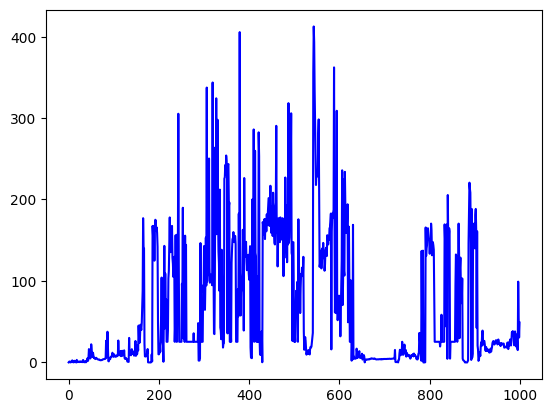

episode:   0 | score avg: 33.27 | memory length: 2000 | epsilon: 0.0100


KeyboardInterrupt: 

In [5]:
# play saved model
agent.model.load_weights("./save_model/model")
agent.epsilon = 0.01
env = gym.make('CartPole-v1', render_mode = 'human')
plt.plot(episodes, scores, 'b')
plt.show()

for e in range(5):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state[0], [1, state_size])
        count = 1
        Left, Right = False, False
        while not done:
            if agent.render:
                env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done, info, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            
            #set new done with less consideration with angle
            # transform reward system so that it repeats left and right while maintaining balance
            pos = next_state[0][0]
            vel = next_state[0][1]
            angle = next_state[0][2]
            angle_vel = next_state[0][3]
            
            
            # get less consideration with angle
            if pos>-2.4 and pos<2.4 and angle>-0.4 and angle<0.4:
                done = False
                if pos < -2.0 and angle > 0 and angle_vel ==0:
                    Left = True
                    if Right == True:
                        count += 1
                    reward = 0.1*count
                elif pos > 2.0 and angle < 0 and angle_vel ==0:
                    Right = True
                    if Left == True:
                        count += 1
                    reward = 0.1*count
                else:
                    reward = 0.1*count
            else:
                done = True
                Left = False
                Right = False
                reward = -1
                
            score += reward

            state = next_state
            if done:
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print("episode: {:3d} | score avg: {:3.2f} | memory length: {:4d} | epsilon: {:.4f}".format(
                      e, score_avg, len(agent.memory), agent.epsilon))
                
pygame.quit()